In [1]:
import numpy as np
import scipy as sp
import pandas as pd

import gudhi as gh
import networkx as nx


import itertools

import meshplot as mp
import matplotlib.pyplot as plt
import seaborn as sns

# Create Shapes

In [2]:
def merge_meshes_with_weld(V0, F0, V1, F1, tol=1e-9):
    """
    Объединяет 2 меша и 'сваривает' совпадающие вершины.
    V*: (N,3) float, F*: (M,3) int (0-based).
    tol: геом. допуск (в тех же единицах, что и координаты).

    Возвращает: V_merged, F_merged, (map0, map1)
      map0: отображение старых индексов V0 -> новых индексов
      map1: отображение старых индексов V1 -> новых индексов
    """
    # 1) складываем вершины в один массив
    V = np.vstack([V0, V1])

    # 2) квантизация (устойчивая сварка для float)
    #    ключ = округление координат к сетке tol
    if tol <= 0:
        raise ValueError("tol must be > 0")
    Q = np.round(V / tol).astype(np.int64)

    # 3) unique по строкам: получаем новые вершины и отображение old->new
    #    inv[i] = индекс уникальной вершины для старой вершины i
    uniqQ, uniq_idx, inv = np.unique(Q, axis=0, return_index=True, return_inverse=True)

    V_merged = V[uniq_idx]

    # 4) перенумеровываем грани
    F0_new = inv[F0]
    F1_shifted = F1 + len(V0)
    F1_new = inv[F1_shifted]

    F_merged = np.vstack([F0_new, F1_new])

    # (опционально) убрать вырожденные треугольники, которые могли появиться после сварки
    # например, если два или три индекса в треугольнике совпали
    good = (F_merged[:,0] != F_merged[:,1]) & (F_merged[:,1] != F_merged[:,2]) & (F_merged[:,0] != F_merged[:,2])
    F_merged = F_merged[good]

    map0 = inv[:len(V0)]
    map1 = inv[len(V0):]

    return V_merged, F_merged, (map0, map1)

In [3]:
def rotate_over_x(points, angle):
    c, s = np.cos(angle), np.sin(angle)
    R = np.array([[1, 0, 0],
                  [0, c, -s],
                  [0, s,  c]])
    return points @ R.T

def rotate_over_y(points, angle):
    c, s = np.cos(angle), np.sin(angle)
    R = np.array([[c, 0, s],
                  [0, 1, 0],
                  [-s, 0, c]])
    return points @ R.T

def rotate_over_z(points, angle):
    c, s = np.cos(angle), np.sin(angle)
    R = np.array([[c, -s, 0],
                  [s,  c, 0],
                  [0,  0, 1]])
    return points @ R.T

In [4]:

def rotate_over_axis(points, angle, cord=0):
    """
    """
    c, s = np.cos(angle), np.sin(angle)
    R = np.zeros(shape=(3, 3))
    R[cord, cord] = 1
    R[np.arange(3) != cord][np.arange(3) != cord] = [[c, -s], [-s, c]]
    print(R)
    return points @ R.T


## Glued Torus

In [5]:
def get_tor_cords(phi, psi, R=2, r=1):
    x = (R + r*np.cos(psi)) * np.cos(phi)
    y = (R + r*np.cos(psi)) * np.sin(phi)
    z = r * np.sin(psi)
    return np.column_stack([x, y, z])


In [6]:
def get_torus_triangulation(n, m):
    faces = []
    for x, y, in itertools.product(range(n), range(m)):
        v00 = m*x + y
        v01 = m*((x + 1)%n) + y
        v10 = m*x + (y + 1)%m
        v11 = m*((x + 1)%n) + (y + 1)%m
        if (x + y)%2 == 0:
            faces.append([v00, v01, v11])
            faces.append([v00, v10, v11])
        else:
            faces.append([v00, v01, v10])
            faces.append([v01, v10, v11])
    
    faces = np.array(faces)
    return faces

In [7]:
n = 36
m = 24

phi = np.arange(n)/n*2*np.pi
psi = np.arange(m)/m*2*np.pi
phi = np.repeat(phi, m)
psi = np.tile(psi, n)

R, r = 2, 1
glued_torus_vertices = get_tor_cords(phi, psi, R, r)
glued_torus_faces = get_torus_triangulation(n, m)

# glue the hole
disk_border_idx = np.argwhere(abs(np.linalg.norm(glued_torus_vertices, axis=1) - r) < 1e-5).ravel()
disk_border_pts = glued_torus_vertices[disk_border_idx][:, [0, 1]]
disk_triangulation_local = sp.spatial.Delaunay(disk_border_pts).simplices
disk_triangulation_global = disk_border_idx[disk_triangulation_local]
glued_torus_faces = np.vstack([glued_torus_faces, disk_triangulation_global])




mp.plot(glued_torus_vertices, glued_torus_faces, c=np.array([0.5, 0.5, 1.0]), shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [8]:
def rotate_over_axis(points, angle, cord=0):
    """
    """
    c, s = np.cos(angle), np.sin(angle)
    R = np.zeros(shape=(3, 3))
    R[cord, cord] = 1
    i, j = np.where(np.arange(3) != cord)[0]
    R[i, i] = c
    R[i, j] = -s
    R[j, i] = s
    R[j, j] = c
    return points @ R.T

In [9]:
rotate_over_axis(glued_torus_vertices, angle=0.2*np.pi)

array([[ 3.        ,  0.        ,  0.        ],
       [ 2.96592583, -0.15213002,  0.20938901],
       [ 2.8660254 , -0.29389263,  0.4045085 ],
       ...,
       [ 2.66597975,  0.03532086, -0.84836994],
       [ 2.82248404, -0.10873902, -0.69703751],
       [ 2.92086675, -0.26453608, -0.51211464]], shape=(864, 3))

## 2 Linked Tori

In [10]:
n0, n1 = 24, 36
r0, r1 = 0.4, 0.6

alpha0 = 2*np.pi/n0
alpha1 = 2*np.pi/n1
phi0 = alpha0*np.arange(n0)
phi1 = alpha1*np.arange(n1)
circle0 = np.column_stack([-r0*np.cos(phi0) + r0, r0*np.sin(phi0), np.zeros(n0)])
circle1 = np.column_stack([+r1*np.cos(phi1) - r1, np.zeros(n1), r1*np.sin(phi1)])


torus0_vertices = np.concatenate([rotate_over_y(circle0 + np.array([r1, 0, 0]), i*alpha1) - np.array([r1, 0, 0]) for i in range(n1)])
torus1_vertices = np.concatenate([rotate_over_z(circle1 + np.array([-r0, 0, 0]), i*alpha0) + np.array([r0, 0, 0])for i in range(n0)])

torus0_faces = get_torus_triangulation(n1, n0)
torus1_faces = get_torus_triangulation(n0, n1)

p = mp.plot(torus0_vertices, torus0_faces, c=np.array([1.0, 0.5, 0.5]), shading={"wireframe": True})
p.add_mesh(torus1_vertices, torus1_faces, c=np.array([0.5, 0.5, 1.0]), shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.599999…

1

In [11]:
linked_tori_vertices, linked_tori_faces, (map0, map1) = merge_meshes_with_weld(torus0_vertices, torus0_faces, torus1_vertices, torus1_faces, tol=1e-8)

mp.plot(linked_tori_vertices, linked_tori_faces, c=np.array([1.0, 0.5, 1.0]), shading={"wireframe": True})


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

## 3 Glued halftori


In [12]:
def get_halftorus(r=1, R=2, l0=1, l1=2, n=24, m=36, glue=True, tol=1e-6):
    """
    """
    phi = np.arange(n)/(n - 1)*np.pi
    psi = np.arange(m)/m*2*np.pi

    vertices_torus = []
    for p in phi:
        for s in psi:
            x = (R + r * np.cos(s)) * np.cos(p)
            y = (R + r * np.cos(s)) * np.sin(p)
            z = r * np.sin(s)
            vertices_torus.append((x, y, z))

    faces_torus = []
    for i in range(n - 1):
        for j in range(m):
            next_i = (i + 1) % n
            next_j = (j + 1) % m
            v0 = i*m + j
            v1 = next_i*m + j
            v2 = next_i*m + next_j
            v3 = i*m + next_j
            if (i + j) % 2 == 0:
                faces_torus.append([v0, v1, v2])
                faces_torus.append([v0, v2, v3])
            else:
                faces_torus.append([v1, v2, v3])
                faces_torus.append([v0, v1, v3])

    vertices = np.array(vertices_torus)
    faces = np.array(faces_torus)

    # Продлеваю край (геометрия для phi=0)
    x = np.cos(psi)
    z = np.sin(psi)
    y = -(np.abs(z)*l0 + (1 - np.abs(z))*l1)
    x = r*x + R
    z = r*z

    vertices_extra0 = np.stack([ x, y, z], axis=1)   # для phi=0
    vertices_extra1 = np.stack([-x, y, z], axis=1)   # для phi=pi (зеркалим по x)

    base0 = n * m
    base1 = base0 + m

    # индексы колец края
    edge0 = 0 * m
    edge1 = (n - 1) * m

    j  = np.arange(m)
    jn = (j + 1) % m

    # --- лента для phi=0 ---
    v_edge_j0  = edge0 + j
    v_edge_jn0 = edge0 + jn
    v_ex_j0    = base0 + j
    v_ex_jn0   = base0 + jn

    faces_extra0 = np.vstack([
        np.stack([v_edge_j0,  v_ex_j0,  v_ex_jn0], axis=1),
        np.stack([v_edge_j0,  v_ex_jn0, v_edge_jn0], axis=1),
    ])

    # --- лента для phi=pi ---
    v_edge_j1  = edge1 + j
    v_edge_jn1 = edge1 + jn
    v_ex_j1    = base1 + j
    v_ex_jn1   = base1 + jn

    faces_extra1 = np.vstack([
        np.stack([v_edge_j1,  v_ex_j1,  v_ex_jn1], axis=1),
        np.stack([v_edge_j1,  v_ex_jn1, v_edge_jn1], axis=1),
    ])

    # собираем
    vertices_extra = np.vstack([vertices_extra0, vertices_extra1]).astype(float)
    faces_extra    = np.vstack([faces_extra0, faces_extra1]).astype(int)

    vertices = np.concatenate([vertices, vertices_extra], axis=0)
    faces    = np.concatenate([faces, faces_extra], axis=0)


    if glue:
        # glue the hole
        disk_border_idx = np.argwhere(abs(np.linalg.norm(vertices, axis=1) - r) < tol).ravel()
        disk_border_idx = np.append(disk_border_idx, n*m + m//2)
        disk_border_idx = np.append(disk_border_idx, n*m + m + m//2)
        
        disk_border_pts = vertices[disk_border_idx]
        disk_border_pts = disk_border_pts[:, [0, 1]]

        disk_triangulation_local = sp.spatial.Delaunay(disk_border_pts, furthest_site=True).simplices
        disk_triangulation_global = disk_border_idx[disk_triangulation_local]
        faces = np.vstack([faces, disk_triangulation_global])


    vertices[:, 1] += l1

    return vertices, faces


In [13]:
n, m = 24, 36
glue = True
halftorus_vertices, halftorus_faces = get_halftorus(n=n, m=m, glue=glue)


print(f'vertices.shape = {halftorus_vertices.shape}, faces.shape = {halftorus_faces.shape}')

assert len(halftorus_vertices) == n*m + 2*m
assert len(halftorus_faces) == 2*(n - 1)*m + 4*m + glue*n

p = mp.plot(halftorus_vertices, halftorus_faces, c=np.array([1.0, 0.5, 0.5]), shading={"wireframe": True})

vertices.shape = (936, 3), faces.shape = (1824, 3)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 2.49…

In [14]:
def get_halftori_bouquet(leaves=3, r=1, R=2, l0=1, n=6, m=6, glue=True, tol=1e-6):
    l1 = l0 + r/np.tan(np.pi/leaves)

    vertices0, faces0 = get_halftorus(r, R, l0, l1, n, m, glue, tol)
    vertices, faces = vertices0.copy(), faces0.copy()
    for i in range(1, leaves):
        angle = i * (2 * np.pi / leaves)
        rotated_vertices = rotate_over_x(vertices0, angle)
        vertices, faces, _ = merge_meshes_with_weld(vertices, faces, rotated_vertices, faces0, tol)
    return vertices, faces

In [15]:
n, m = 36, 36
glue = True
halftori_bouquet3_vertices, halftori_bouquet3_faces = get_halftori_bouquet(3, n=n, m=m, glue=glue)
print(f'vertices.shape = {halftori_bouquet3_vertices.shape}, faces.shape = {halftori_bouquet3_faces.shape}')


assert len(halftori_bouquet3_vertices) == 3*n*m + 3*m - 2
assert len(halftori_bouquet3_faces) == 3*(2*(n - 1)*m + 4*m + glue*n)

p = mp.plot(halftori_bouquet3_vertices, halftori_bouquet3_faces, c=0.5*np.ones(3), shading={"wireframe": True})

vertices.shape = (3994, 3), faces.shape = (8100, 3)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.89…

# Detect Nonmanifold Parts 

## Define CW-Complex from triangulation

In [16]:
def get_edge_valence(faces):
    """
    faces: (M,3) int
    Возвращает: dict {edge_tuple: valence}
    """
    edge_valence = {}
    for tri in faces:
        edges = [(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])]
        for e in edges:
            e_sorted = tuple(sorted(e))
            if e_sorted not in edge_valence:
                edge_valence[e_sorted] = 0
            edge_valence[e_sorted] += 1
    return edge_valence

In [17]:
def get_path(g: nx.Graph):
    num_connected_components = nx.number_connected_components(g)
    assert num_connected_components == 1

    nodes, degrees = np.transpose(list(g.degree()))
    assert (degrees <= 2).all()

    if (degrees == 2).all():
        new_g = g.copy()
        new_g.remove_edge(*next(iter(g.edges())))
        path = get_path(new_g)
        path = np.append(path, path[0])
        return path
    
    node0, node1 = nodes[degrees == 1]
    path = nx.shortest_path(g, node0, node1)
    path = np.array(path)
    return path

In [18]:
class SubmanifoldsRepresentation2d():
    def __init__(self, triangulation):
        # check triangulation
        self.triangles = np.array(triangulation)
        assert self.triangles.ndim == 2
        assert self.triangles.shape[-1] == 3

        # get edge valencies
        edge_valency_dict = get_edge_valence(self.triangles)
        self.edges = np.array(list(edge_valency_dict.keys()))
        self.edges = np.sort(self.edges, axis=1)
        self.edges_valencies = np.array(list(edge_valency_dict.values()))

        # Generate cells
        triangles_in_cell_connectivity_graph = nx.Graph()
        for (vertex0, vertex1) in self.edges[self.edges_valencies == 2]:
            tri0, tri1 = np.argwhere((np.array(self.triangles) == vertex0).any(axis=1) & (np.array(self.triangles) == vertex1).any(axis=1)).flatten()
            triangles_in_cell_connectivity_graph.add_edge(tri0, tri1)
        
        self.triangles_cells = np.zeros(len(self.triangles), dtype=int) - 1
        for i_cell, component in enumerate(nx.connected_components(triangles_in_cell_connectivity_graph)):
            self.triangles_cells[list(component)] = i_cell
        
        self.ncells = self.triangles_cells.max() + 1
        assert self.ncells == len(np.unique(self.triangles_cells))

        # 
        self.vertex_connectivity_graph = nx.Graph()
        self.vertex_connectivity_graph.add_edges_from(self.triangles[:, [0, 1]])
        self.vertex_connectivity_graph.add_edges_from(self.triangles[:, [1, 2]])
        self.vertex_connectivity_graph.add_edges_from(self.triangles[:, [1, 2]])

        
    def get_cell_colors(self, cmap='winter'):
        cmap = plt.get_cmap(cmap)
        colors = cmap(self.triangles_cells/self.triangles_cells.max())[:, :3]
        return colors
    
    def get_cell_boundaries_graph(self):
        try:
            return self.cell_boundaries_graph
        except AttributeError:
            self.cell_boundaries_graph = nx.Graph()
            self.cell_boundaries_graph.add_nodes_from(range(self.ncells))
            for cell0, cell1 in itertools.combinations(range(self.ncells), 2):
                vertices0 = np.unique(self.triangles[self.triangles_cells == cell0])
                vertices1 = np.unique(self.triangles[self.triangles_cells == cell1])
                intersection = np.intersect1d(vertices0, vertices1)
                if len(intersection) > 0:
                    g = self.vertex_connectivity_graph.subgraph(intersection).copy()
                    g = g.edge_subgraph([tuple(e) for e in self.edges[self.edges_valencies > 2]]).copy()
                    boundary = get_path(g)
                    self.cell_boundaries_graph.add_edge(cell0, cell1, boundary=boundary.copy())
            return self.cell_boundaries_graph

    def iterate_boundaries_curves(self, vertices=None):
        self.get_cell_boundaries_graph()

        for cell0, cell1, boundary in self.cell_boundaries_graph.edges(data='boundary'):
            if vertices is None:
                yield boundary
            else:
                yield vertices[boundary]



In [19]:
glued_torus_rep = SubmanifoldsRepresentation2d(glued_torus_faces)

face_colors = glued_torus_rep.get_cell_colors()
p = mp.plot(glued_torus_vertices, glued_torus_faces, face_colors, shading={"wireframe": True})

for curve in glued_torus_rep.iterate_boundaries_curves():
    for i in range(len(curve) - 1):
        point0, point1 = glued_torus_vertices[curve[[i, i+1]]]
        p.add_lines(point0, point1, shading={"line_color": "red", "line_width": 1.0})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [20]:
linked_tori_rep = SubmanifoldsRepresentation2d(linked_tori_faces)

face_colors = linked_tori_rep.get_cell_colors()
p = mp.plot(linked_tori_vertices, linked_tori_faces, face_colors, shading={"wireframe": True})

#for curve in linked_tori_rep.iterate_boundaries_curves():
#    for i in range(len(curve) - 1):
#        point0, point1 = linked_tori_vertices[curve[[i, i+1]]]
#        p.add_lines(point0, point1, shading={"line_color": "red", "line_width": 1.0})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

# Increase Triangulation Resolution

In [21]:
def split_edge(vertices, faces, e0, e1):
    # 
    new_vertex = 0.5*(vertices[e0] + vertices[e1])
    new_index = len(vertices)
    new_vertices = np.concatenate([vertices, [new_vertex]])

    faces_cond = (faces == e0).any(axis=1) & (faces == e1).any(axis=1)
    updating_simplices_vertices = np.unique(faces[faces_cond])
    updating_simplices_vertices = updating_simplices_vertices[~np.isin(updating_simplices_vertices, [e0, e1])]
    new_faces = np.concatenate([faces[~faces_cond], 
                                [(e0, new_index, v) for v in updating_simplices_vertices], 
                                [(e1, new_index, v) for v in updating_simplices_vertices]])
    return new_vertices, new_faces


def split_large_edges(vertices, faces, max_length=1.0):
    # 
    new_vertices, new_faces = vertices.copy(), faces.copy()

    def get_max_edge_length(V, F):
        edges = np.concatenate([F[:, [0, 1]], F[:, [0, 2]], F[:, [1, 2]]])
        edges = np.unique(np.sort(edges, axis=1), axis=0)
        edges_lengths = np.linalg.norm(V[edges[:, 0]] - V[edges[:, 1]], axis=1)
        max_length_idx = np.argmax(edges_lengths)
        e0, e1 = edges[max_length_idx]
        l = edges_lengths[max_length_idx]
        return e0, e1, l
    
    e0, e1, l = get_max_edge_length(new_vertices, new_faces)
    while l > max_length:
        new_vertices, new_faces = split_edge(new_vertices, new_faces, e0, e1)
        e0, e1, l = get_max_edge_length(new_vertices, new_faces)
    return new_vertices, new_faces



In [22]:
n, m = 12, 12
vertices, faces = get_halftori_bouquet(leaves=3, n=n, m=m, glue=True)
print(f'Before the split there were {len(vertices)} vertices and {len(faces)} faces')

vertices, faces = split_large_edges(vertices, faces, max_length=1.4)
print(f'After the split there are {len(vertices)} vertices and {len(faces)} faces')

p = mp.plot(vertices, faces, shading={"wireframe": True})

Before the split there were 466 vertices and 972 faces
After the split there are 533 vertices and 1113 faces


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.88…

# Manifold Morse

In [23]:
def get_linear_morse(vector=None):
    if vector is None:
        vector = np.random.random(4)
    vector = np.array(vector)
    def f(points):
        return points @ vector
    return f

direction = np.random.random(3)
direction /= np.linalg.norm(direction)

In [24]:
f0 = get_linear_morse([0, 1, 0])

f = lambda p: f0(p)

In [25]:
n, m = 13, 12
#n, m = 25, 24
vertices, faces = get_halftori_bouquet(leaves=2, n=n, m=m, glue=False)
#vertices, faces = split_large_edges(vertices, faces, max_length=0.6)
vertices, faces = split_large_edges(vertices, faces, max_length=1.1)

#vertices += 0.05*np.random.normal(size=vertices.shape)


print(f'faces.shape = {faces.shape}')

face_colors = f(vertices[faces]).mean(axis=1)

p = mp.plot(vertices, faces, face_colors, shading={"wireframe": True})

faces.shape = (768, 3)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [65]:
def get_next_vertices(vertex, faces, f, f_dist=None, direction_up=True):
    """
    """
    neighbourhood_faces = faces[(faces == vertex).any(axis=1)]
    if f_dist is None:
        f_dist = lambda v0, v1: abs(f(v1))
    
    neighbourhood_graph = nx.Graph()
    neighbourhood_graph.add_edges_from(neighbourhood_faces[:, [0, 1]])
    neighbourhood_graph.add_edges_from(neighbourhood_faces[:, [0, 2]])
    neighbourhood_graph.add_edges_from(neighbourhood_faces[:, [1, 2]])

    neighbourhood_vertices = np.unique(neighbourhood_faces)
    neighbourhood_values = f(neighbourhood_vertices) - f(vertex)
    if direction_up:
        forward_vertices = neighbourhood_vertices[neighbourhood_values > 0]
    else:
        forward_vertices = neighbourhood_vertices[neighbourhood_values < 0]
        
    next_vertices = [np.array(list(component)) for component in nx.connected_components(neighbourhood_graph.subgraph(forward_vertices))]
    next_vertices = [component[np.argmax(f_dist(vertex, component))] for component in next_vertices]

    return next_vertices

    


In [101]:
morse_function = lambda v: f(vertices[v])
distance_function = lambda v0, v1: np.linalg.norm(vertices[v1] - vertices[v0], axis=-1)
distance_function = lambda v0, v1: np.linalg.norm(vertices[v1] - vertices[v0], axis=-1)*abs(morse_function(v0) - morse_function(v1))

df_points = pd.DataFrame({'vertex': np.unique(faces), 'pos':list (vertices)})
df_points['upper_vertices'] = df_points['vertex'].apply(lambda vertex: get_next_vertices(vertex, faces, f=morse_function, f_dist=distance_function, direction_up=True))
df_points['lower_vertices'] = df_points['vertex'].apply(lambda vertex: get_next_vertices(vertex, faces, f=morse_function, f_dist=distance_function, direction_up=False))
df_points['upper_cnt'] = df_points['upper_vertices'].apply(len)
df_points['lower_cnt'] = df_points['lower_vertices'].apply(len)

def get_vertex_type_row(row):
    upper = row['upper_cnt']
    lower = row['lower_cnt']

    if upper + lower == 0:
        return 'isolated'
    if (upper == 1) and (lower == 1):
        return 'regular'
    if (upper == 0) and (lower == 1):
        return 'max'
    if (upper == 1) and (lower == 0):
        return 'min'
    return 'saddle'

df_points['type'] = df_points.apply(get_vertex_type_row, axis=1)

print(f'df_points.shape = {df_points.shape}')
df_points.head()

df_points.shape = (384, 7)


,vertex,pos,upper_vertices,lower_vertices,upper_cnt,lower_cnt,type
0,0,"[-3.0, -1.0000000000000004, 1.2246467991473537...",[1],[11],1,1,regular
1,1,"[-3.0, 0.0, 0.0]",[2],[0],1,1,regular
2,2,"[-3.0, 1.0000000000000004, 0.0]",[13],[1],1,1,regular
3,3,"[-2.8977774788672046, -1.776457135307563, 2.17...",[0],[15],1,1,regular
4,4,"[-2.8977774788672046, 1.776457135307563, 0.0]",[16],[2],1,1,regular


In [102]:
df_points['type'].value_counts()

type
regular    380
saddle       2
min          1
max          1
Name: count, dtype: int64

In [103]:
df_points[df_points['type'] != 'regular']

,vertex,pos,upper_vertices,lower_vertices,upper_cnt,lower_cnt,type
156,156,"[1.8369701987210297e-16, -4.0, 4.8985871965894...",[127],[],1,0,min
167,167,"[6.123233995736766e-17, -2.0, 1.22464679914735...","[154, 180]","[165, 166]",2,2,saddle
168,168,"[6.123233995736766e-17, 2.0, 1.224646799147353...","[170, 169]","[155, 181]",2,2,saddle
179,179,"[1.8369701987210297e-16, 4.0, 0.0]",[],[128],0,1,max


In [104]:
vertex_type_colors_dict = {
    'min': "lime", 
    'saddle': "gold", 
    'max': 'orangered', 
    'regular': 'gray'
}

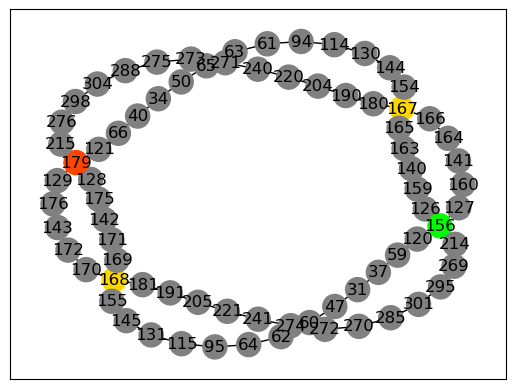

In [105]:
assert (df_points['vertex'] == df_points.index).all()

graph_paths = nx.Graph()


for next_col  in ['upper_vertices', 'lower_vertices']:
    end_points = df_points[df_points['type'] == 'saddle']['vertex'].values

    while len(end_points) > 0:
        df_new_edges = df_points.loc[end_points][['vertex', next_col]]
        df_new_edges = df_new_edges[df_new_edges[next_col].apply(len) > 0]
        if len(df_new_edges) == 0:
            break
        df_new_edges['edges'] = df_new_edges.apply(lambda row: [(row['vertex'], v) for v in row[next_col]], axis=1)
        
        
        new_edges = np.concatenate(df_new_edges['edges'].values)
        graph_paths.add_edges_from(new_edges)

        end_points = np.unique(np.concatenate(df_new_edges[next_col].values))
    

pos_paths = nx.kamada_kawai_layout(graph_paths)
node_color = df_points.loc[list(graph_paths.nodes())]['type'].apply(lambda t: vertex_type_colors_dict[t])


nx.draw_networkx(graph_paths, pos=pos_paths, node_color=node_color)

In [106]:
df_points.loc[list(graph_paths.nodes)]

,vertex,pos,upper_vertices,lower_vertices,upper_cnt,lower_cnt,type
167,167,"[6.123233995736766e-17, -2.0, 1.22464679914735...","[154, 180]","[165, 166]",2,2,saddle
154,154,"[-0.25881904510252085, -1.9659258262890682, 1....",[144],[151],1,1,regular
180,180,"[0.25881904510252074, -1.9659258262890682, 1.1...",[190],[183],1,1,regular
168,168,"[6.123233995736766e-17, 2.0, 1.224646799147353...","[170, 169]","[155, 181]",2,2,saddle
170,170,"[6.943591797848996e-17, 2.133974596215561, 0.4...",[172],[168],1,1,regular
...,...,...,...,...,...,...,...
295,295,"[2.0265859980688896, -3.0265859980688896, -0.4...",[301],[269],1,1,regular
59,59,"[-1.4999999999999993, -3.598076211353316, 4.40...",[37],[120],1,1,regular
269,269,"[1.5000000000000004, -3.598076211353316, 4.406...",[296],[214],1,1,regular
120,120,"[-0.7764571353075626, -3.897777478867205, 4.77...",[59],[156],1,1,regular


In [107]:
p = mp.plot(vertices, faces, face_colors, shading={"wireframe": False})

for critical_type, color in vertex_type_colors_dict.items():
    if critical_type != 'regular':
        p.add_points(vertices[df_points.loc[df_points['type'] == critical_type, 'vertex'].values], c=color, shading={"point_size": 1.0})

path_edges = vertices[np.array(list(graph_paths.edges()))]
p.add_lines(path_edges[:, 0], path_edges[:, 1], shading={'line_color': 'white'})


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

4

In [108]:
df_points[['type', 'upper_cnt', 'lower_cnt', ]].value_counts().reset_index()

,type,upper_cnt,lower_cnt,count
0,regular,1,1,380
1,saddle,2,2,2
2,min,1,0,1
3,max,0,1,1


In [109]:
paths = []

for saddle in df_points[df_points['type'] == 'saddle']['vertex']:
    for col_name in ['upper_vertices', 'lower_vertices']:
        for second_point in df_points.loc[saddle, col_name]:
            path = [saddle, second_point]
            while len(df_points.loc[path[-1], col_name]) == 1:
                path.append(df_points.loc[path[-1], col_name][0])
            if len(df_points.loc[path[-1], col_name]) != 0:
                print(f'Warning: {path[-1]} -> {df_points.loc[path[-1], col_name]}')
            paths.append(np.array(path))

df_paths = pd.DataFrame({'path': paths})
df_paths['start'] = df_paths['path'].apply(lambda s: s[0])
df_paths['finish'] = df_paths['path'].apply(lambda s: s[-1])
df_paths['direction'] = df_points.loc[df_paths['finish'].values]['type'].map({'max': 'increasing', 'min': 'decreasing'}).values
df_paths.insert(0, 'index', df_paths.index)

from matplotlib.colors import to_hex
df_paths['color'] = [to_hex(c) for c in plt.get_cmap('jet')(np.linspace(0, 1, len(df_paths)))]


print(f'df_paths.shape = {df_paths.shape}')
df_paths.head()

df_paths.shape = (8, 6)


,index,path,start,finish,direction,color
0,0,"[167, 154, 144, 130, 114, 94, 61, 63, 65, 50, ...",167,179,increasing,#000080
1,1,"[167, 180, 190, 204, 220, 240, 271, 273, 275, ...",167,179,increasing,#0010ff
2,2,"[167, 165, 163, 140, 159, 126, 156]",167,156,decreasing,#00a4ff
3,3,"[167, 166, 164, 141, 160, 127, 156]",167,156,decreasing,#40ffb7
4,4,"[168, 170, 172, 143, 176, 129, 179]",168,179,increasing,#b7ff40


In [110]:
p = mp.plot(vertices, faces, np.ones(3), shading={"wireframe": False})

for critical_type, color in vertex_type_colors_dict.items():
    if critical_type != 'regular':
        p.add_points(vertices[df_points.loc[df_points['type'] == critical_type, 'vertex'].values], c=color, shading={"point_size": 1.0})

for i, row in df_paths.iterrows():
    path = row['path']
    color = row['color']

    p.add_lines(vertices[path[:-1]], vertices[path[1:]], shading={'line_color': color})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [112]:
df_paths_intersections = df_paths.merge(df_paths, how="cross", suffixes=("0", "1"))
df_paths_intersections['intersection_length'] = df_paths_intersections.apply(lambda row: np.intersect1d(row['path0'], row['path1']), axis=1).apply(len)

df_interlength = df_paths_intersections.pivot_table(columns=['start1', 'finish1', 'index1'], index=['start0', 'finish0', 'index0'], values='intersection_length').astype(int)

df_interlength
#sns.heatmap(df_interlength)

start1                167            168           
finish1               156    179     156     179   
index1                  2  3   0   1   6   7   4  5
start0 finish0 index0                              
167    156     2        7  2   1   1   1   1   0  0
               3        2  7   1   1   1   1   0  0
       179     0        1  1  15   2   0   0   1  1
               1        1  1   2  15   0   0   1  1
168    156     6        1  1   0   0  15   2   1  1
               7        1  1   0   0   2  15   1  1
       179     4        0  0   1   1   1   1   7  2
               5        0  0   1   1   1   1   2  7